In [2]:
import pandas as pd
import os
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
rdf = pd.read_csv('model/merged_marginal_data.csv')
rdf

,Year,Month,Day,Hour,Price1,Hour_Sin,Hour_Cos
0,2023,4.0,21.0,1.0,122.50,2.588190e-01,0.965926
1,2023,4.0,21.0,2.0,112.39,5.000000e-01,0.866025
2,2023,4.0,21.0,3.0,117.60,7.071068e-01,0.707107
3,2023,4.0,21.0,4.0,119.84,8.660254e-01,0.500000
4,2023,4.0,21.0,5.0,115.01,9.659258e-01,0.258819
...,...,...,...,...,...,...,...
8755,2023,6.0,27.0,20.0,115.70,-8.660254e-01,0.500000
8756,2023,6.0,27.0,21.0,121.10,-7.071068e-01,0.707107
8757,2023,6.0,27.0,22.0,127.60,-5.000000e-01,0.866025
8758,2023,6.0,27.0,23.0,125.06,-2.588190e-01,0.965926


In [4]:
data_array = oil_data.values
simple_dates = pd.to_datetime(oil_data.index).date
oil_df = pd.DataFrame({'SimpleDate': simple_dates, 'price_oil': data_array.flatten()})

In [5]:
current_dir = r'C:\Users\tamas\Documents\GitHub\deeplearning'
da_df = pd.read_csv(current_dir + '\\DA_prices.csv')
id_df = pd.read_csv(current_dir + '\\ID_prices.csv')
gas_df = pd.read_csv(current_dir + '\\gas\\MIBGAS_Data_2023.csv', sep=';', skiprows=1).drop('Unnamed: 7', axis=1)

In [6]:
# Convert the date columns to datetime
da_df['Date'] = da_df.apply(
    lambda row: (
        dt.datetime(row['Year'].astype(int), row['Month'].astype(int), row['Day'].astype(int), 23, 59, 59)
        if row['Hour'] == 24
        else dt.datetime(row['Year'].astype(int), row['Month'].astype(int), row['Day'].astype(int), row['Hour'].astype(int))
    ), 
    axis=1
)
id_df['Date'] = id_df.apply(
    lambda row: (
        dt.datetime(row['Year'].astype(int), row['Month'].astype(int), row['Day'].astype(int), 23, 59, 59)
        if row['Hour'] == 24
        else dt.datetime(row['Year'].astype(int), row['Month'].astype(int), row['Day'].astype(int), row['Hour'].astype(int))
    ), 
    axis=1
)

In [7]:
gs_df = gas_df[gas_df['Product'] == 'GDAES_D+1'].copy()
merged_df = pd.merge(id_df, da_df[['Date', 'DA ES']], on=['Date'], how='inner')
# replace date column to the beginning
merged_df = merged_df[['Date'] + [col for col in merged_df.columns if col != 'Date']]
merged_df['SimpleDate'] = merged_df['Date'].dt.date
gs_df['SimpleDate'] = gs_df['Trading day'].apply(lambda x: dt.datetime.strptime(x, '%d/%m/%Y').date())
merged_df = pd.merge(merged_df, gs_df[['SimpleDate', 'MIBGAS Daily Price [EUR/MWh]']], on=['SimpleDate'], how='left')
merged_df = pd.merge(merged_df, oil_df, on=['SimpleDate'], how='left')

In [8]:
# Rename columns in merged df to id_en_max, id_en_min, id_en_avg, da_en, da_gas
merged_df.rename(columns={
    'MaxES': 'id_en_max',
    'MinES': 'id_en_min',
    'AvgES': 'id_en_avg',
    'DA ES': 'da_en',
    'MIBGAS Daily Price [EUR/MWh]': 'da_gas'
}, inplace=True)

# Encoding the date column
merged_df['hour_sin'] = np.sin(2 * np.pi * merged_df['Hour'] / 24)
merged_df['hour_cos'] = np.cos(2 * np.pi * merged_df['Hour'] / 24)
merged_df['month_sin'] = np.sin(2 * np.pi * merged_df['Month'] / 12)
merged_df['month_cos'] = np.cos(2 * np.pi * merged_df['Month'] / 12)
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['Day'] / 31)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['Day'] / 31)

# Drop the SimpleDate column
merged_df.drop('SimpleDate', axis=1, inplace=True)
merged_df.head(5)

,Date,Year,Month,Day,Hour,id_en_max,id_en_min,id_en_avg,da_en,da_gas,price_oil,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos
0,2023-01-01 01:00:00,2023,1,1,1,0.14,-4.00,-0.72,0.0,70.45,NaN,0.258819,0.965926,0.5,0.866025,0.201299,0.97953
1,2023-01-01 02:00:00,2023,1,1,2,0.13,-3.23,-0.45,0.0,70.45,NaN,0.500000,0.866025,0.5,0.866025,0.201299,0.97953
2,2023-01-01 03:00:00,2023,1,1,3,0.12,-9.98,-0.95,0.0,70.45,NaN,0.707107,0.707107,0.5,0.866025,0.201299,0.97953
3,2023-01-01 04:00:00,2023,1,1,4,0.00,-6.49,-3.34,0.0,70.45,NaN,0.866025,0.500000,0.5,0.866025,0.201299,0.97953
4,2023-01-01 05:00:00,2023,1,1,5,0.00,-6.69,-2.87,0.0,70.45,NaN,0.965926,0.258819,0.5,0.866025,0.201299,0.97953


# LSTM

In [9]:
working_df = merged_df[['id_en_max', 'id_en_min', 'id_en_avg', 'da_en', 'da_gas', 'price_oil', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']][:-24]
future_features = merged_df[['id_en_max', 'id_en_min', 'id_en_avg', 'da_gas', 'price_oil', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']][-24:]

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import hstack
from tensorflow.keras.layers import Input, Dense, Lambda, LSTM
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

# Define the Normal Distribution Layer
def normal_distribution_layer(x):
    # Separate the parameters for mean (mu) and standard deviation (sigma)
    mu, sigma = tf.unstack(x, num=2, axis=-1)
    sigma = tf.keras.activations.softplus(sigma) + 1e-6  # Avoid log(0)
    sigma = tf.clip_by_value(sigma, 1e-3, 1e3)  # Clip sigma to a reasonable range
    out_tensor = tf.stack([mu, sigma], axis=-1)
    return out_tensor

# Define the Custom Loss Function
def normal_distribution_loss(y_true, y_pred):
    # Negative log-likelihood of Gaussian distribution
    mu, sigma = tf.unstack(y_pred, num=2, axis=-1)
    sigma = tf.keras.activations.softplus(sigma) + 1e-6  # Avoid log(0)
    nll = 0.5 * tf.math.log(2 * np.pi * tf.square(sigma)) + tf.square(y_true - mu) / (2 * tf.square(sigma))
    return tf.reduce_mean(nll)

# Split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = [], []
    for i in range(len(sequences) - n_steps):
        seq_x = sequences[i:i + n_steps, :-1]  # Input features
        seq_y = sequences[i + n_steps - 1, -1]  # Target variable (last column)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Load and Preprocess the Data
# Assuming `working_df` is already loaded
if working_df.isnull().any().any():
    print("Missing values detected. Filling with forward fill.")
    working_df = working_df.fillna(method='ffill').fillna(method='bfill')

# Scale the Dataset
scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(working_df.values)  # Scale all columns together

# Define Parameters
n_steps = 48  # Sequence length

# Create Sequences
X, y = split_sequences(dataset_scaled, n_steps)
print(f"Shapes - X: {X.shape}, y: {y.shape}")

# Build the Model
n_features = X.shape[2]
inputs = Input(shape=(n_steps, n_features))
x = LSTM(50, activation='relu')(inputs)
x = Dense(2)(x)  # Output 2 values (mu and sigma)
outputs = Lambda(normal_distribution_layer)(x)
model = Model(inputs=inputs, outputs=outputs)

# Compile the Model
model.compile(optimizer='adam', loss=normal_distribution_loss)

# Train the Model
model.fit(X, y, epochs=200, verbose=1)

# Prepare the Input for Prediction
x_input = dataset_scaled[-n_steps:, :-1]  # Exclude the target column
x_input = x_input.reshape((1, n_steps, n_features))  # Reshape for the model

# Generate Predictions
predictions = []
for step in range(24):
    yhat = model.predict(x_input, verbose=0)
    mu, sigma = yhat[0, 0], yhat[0, 1]
    predictions.append((mu, sigma))
    print(f"Prediction {step + 1}: da_en = {mu:.2f}, Uncertainty (σ) = {sigma:.2f}")

Epoch 1/200
mu: [nan nan nan ... nan 0.116487801 0.106808692] sigma: [nan nan nan ... nan 1.05353642 1.06003821] y_true: [0.503545463 0.31431818 0.688863635 ... 0.400318176 0.687545478 0.320818186]
  1/272 ━━━━━━━━━━━━━━━━━━━━ 5:02 1s/step - loss: nanmu: [nan nan nan ... nan nan nan] sigma: [nan nan nan ... nan nan nan] y_true: [0.411363631 0.59436363 0.0189090911 ... 0.376590908 0.431818187 0.549409091]
mu: [nan nan nan ... nan nan nan] sigma: [nan nan nan ... nan nan nan] y_true: [0.396954536 0.59009093 0.475045443 ... 0.136818185 0.54095453 0.376590908]
mu: [nan nan nan ... nan nan nan] sigma: [nan nan nan ... nan nan nan] y_true: [0.382454544 0.34163636 0.398272723 ... 0.342727274 0.589727283 0.509772718]
mu: [nan nan nan ... nan nan nan] sigma: [nan nan nan ... nan nan nan] y_true: [0.65990907 0.236318186 0.699181795 ... 0.656909108 0.778090894 0.389409095]
mu: [nan nan nan ... nan nan nan] sigma: [nan nan nan ... nan nan nan] y_true: [0.427363634 0.75 0.182863638 ... 0.364090919 

KeyboardInterrupt: 

In [13]:
history = model.fit(X, y, epochs=200, verbose=1)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 8700
'y' sizes: 36


In [11]:
from scipy.stats import norm

# Perform inference for a single sample
pred_params = model.predict(x_input)
mu = pred_params[:, 0]
stdev = pred_params[:, 1]

# Calculate the probability density function for up to 35 values
y = np.linspace(0, 35, 36)
probs = norm.pdf(y, mu, stdev)

# Calculate the expectation value
y_pred = norm.mean(mu, stdev)

# Calculate the 80% confidence interval
lower, upper = norm.interval(0.8, loc=mu, scale=stdev)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


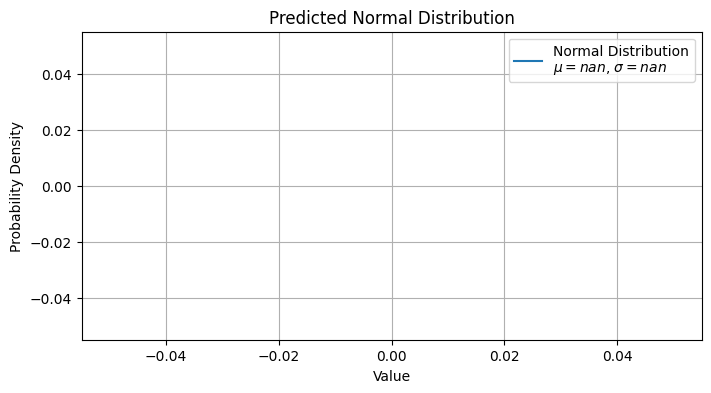

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming `yhat` contains the predicted mu and sigma as [[mu, sigma]]
mu, sigma = yhat[0]  # Get the predicted mu and sigma from yhat

# Generate x values around the predicted mean
x_values = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)

# Compute the PDF of the normal distribution with the predicted mu and sigma
pdf_values = norm.pdf(x_values, mu, sigma)

# Plot the distribution
plt.figure(figsize=(8, 4))
plt.plot(x_values, pdf_values, label=f'Normal Distribution\n$\mu={mu:.2f}$, $\sigma={sigma:.2f}$')
plt.title("Predicted Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()
